In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from imageio import imread
from scipy.spatial import distance
import torch 
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization

import pandas as pd
from tqdm import tqdm
import dlib
from align import AlignDlib
import glob
import imutils


/Users/tranhieu/miniconda/envs/ocr/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# INITIALIZE MODELS
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

nn4_small2 = InceptionResnetV1(
    classify=False,
    pretrained="casia-webface"
).to(device)

nn4_small2.eval()

alignment = AlignDlib('shape_predictor_68_face_landmarks.dat')

cpu


In [3]:
#LOAD TRAINING INFORMATION
train_paths = glob.glob("image/*")
print(train_paths)

nb_classes = len(train_paths)

df_train = pd.DataFrame(columns=['image', 'label', 'name'])

for i,train_path in enumerate(train_paths):
    name = os.path.basename(train_path)
    images = glob.glob(train_path + "/*")
    for image in images:
        df_train.loc[len(df_train)]=[image,i,name]
        
print(df_train.head())

['image/ed_sheeran', 'image/adam_levine', 'image/me', 'image/adele', 'image/taylor_swift']
                                               image  label        name
0  image/ed_sheeran/Screenshot 2024-01-15 at 16.4...      0  ed_sheeran
1  image/ed_sheeran/Screenshot 2024-01-15 at 16.3...      0  ed_sheeran
2  image/ed_sheeran/ed-sheeran_glamour_16mar17_re...      0  ed_sheeran
3  image/ed_sheeran/Screenshot 2024-01-15 at 16.4...      0  ed_sheeran
4  image/ed_sheeran/Screenshot 2024-01-15 at 16.4...      0  ed_sheeran


In [4]:
# PRE-PROCESSING
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

def align_face(face):
    (h,w,c) = face.shape
    bb = dlib.rectangle(0, 0, w, h)
    aligned_face = alignment.align(96, face, bb,landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    return aligned_face
  
def load_and_align_images(filepaths):
    aligned_images = []
    for filepath in filepaths:
        #print(filepath)
        img = cv2.imread(filepath)
        aligned = align_face(img)
        aligned = (aligned / 255.).astype(np.float32)
        aligned = aligned.transpose((2, 0, 1))
        aligned = np.expand_dims(aligned, axis=0)
        aligned_images.append(aligned)
            
    return np.array(aligned_images)
    
def calc_embs(filepaths, batch_size=2): 
    pd = []
    for start in tqdm(range(0, len(filepaths), batch_size)):
        aligned_images = load_and_align_images(filepaths[start:start+batch_size])
        aligned_images = torch.from_numpy(aligned_images).squeeze(1)
        emb = nn4_small2(aligned_images).detach().numpy()
        pd.append(emb)
    #embs = l2_normalize(np.concatenate(pd))
    embs = np.concatenate(pd, axis=0)

    return embs
    
def align_faces(faces):
    aligned_images = []
    for face in faces:
        #print(face.shape)
        aligned = align_face(face)
        aligned = (aligned / 255.).astype(np.float32)
        aligned = aligned.transpose((2, 0, 1))
        aligned_images.append(aligned)
        
    return aligned_images

def calc_emb_test(faces):
    pd = []
    aligned_faces = align_faces(faces)
    aligned_faces = np.array(aligned_faces)
    aligned_faces = torch.from_numpy(aligned_faces)
    pd.append(nn4_small2(aligned_faces).detach().numpy())
    #embs = l2_normalize(np.concatenate(pd))
    embs = np.concatenate(pd, axis=0)
    return np.array(embs)

def trans(img):
    transform = transforms.Compose([
            transforms.ToTensor(),
            fixed_image_standardization
        ])
    return transform(img)

def fixed_image_standardization(image_tensor):
    processed_tensor = (image_tensor - 127.5) / 128.0
    return processed_tensor


In [5]:
# TRAINING
label2idx = []

for i in tqdm(range(len(train_paths))):
    label2idx.append(np.asarray(df_train[df_train.label == i].index))

train_embs = calc_embs(df_train.image)
np.save("train_embs.npy", train_embs)

100%|██████████| 14/14 [00:01<00:00,  8.76it/s]


In [6]:
train_embs = np.load("train_embs.npy")

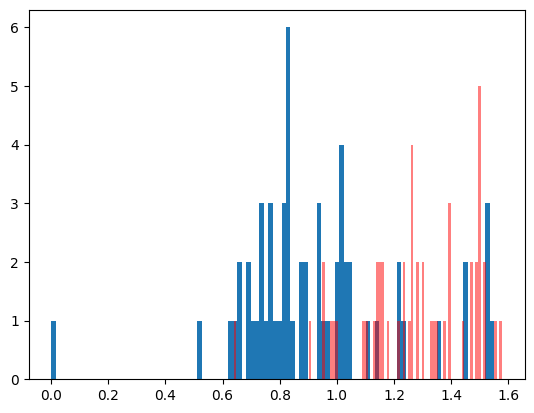

In [7]:
# ANALYSING
import matplotlib.pyplot as plt

match_distances = []
for i in range(nb_classes):
    ids = label2idx[i]
    distances = []
    for j in range(len(ids) - 1):
        for k in range(j + 1, len(ids)):
            distances.append(distance.euclidean(train_embs[ids[j]].reshape(-1), train_embs[ids[k]].reshape(-1)))
    match_distances.extend(distances)
    
unmatch_distances = []
for i in range(nb_classes):
    ids = label2idx[i]
    distances = []
    for j in range(10):
        idx = np.random.randint(train_embs.shape[0])
        while idx in label2idx[i]:
            idx = np.random.randint(train_embs.shape[0])
        distances.append(distance.euclidean(train_embs[ids[np.random.randint(len(ids))]].reshape(-1), train_embs[idx].reshape(-1)))
    unmatch_distances.extend(distances)
    
_,_,_=plt.hist(match_distances,bins=100)
_,_,_=plt.hist(unmatch_distances,bins=100,fc=(1, 0, 0, 0.5))

plt.show()

In [8]:
threshold = 1

In [9]:
# TEST
test_paths = glob.glob("test_image/*.jpg")
for path in test_paths:
    test_image = cv2.imread(path)
    show_image = test_image.copy()

    hogFaceDetector = dlib.get_frontal_face_detector()
    faceRects = hogFaceDetector(test_image, 0)
    
    faces = []
    
    for faceRect in faceRects:
        x1 = faceRect.left()
        y1 = faceRect.top()
        x2 = faceRect.right()
        y2 = faceRect.bottom()
        face = test_image[y1:y2,x1:x2]
        
        faces.append(face)

    print("len(faces) = {0}".format(len(faces)))
    if(len(faces)==0):
        print("no face detected!")
        continue
    else:    
        test_embs = calc_emb_test(faces)
        
    people = []
    for i in range(test_embs.shape[0]):
        distances = []
        for j in range(len(train_paths)):
            distances.append(np.min([distance.euclidean(test_embs[i].reshape(-1), train_embs[k].reshape(-1)) for k in label2idx[j]]))
            #for k in label2idx[j]:
                #print(distance.euclidean(test_embs[i].reshape(-1), train_embs[k].reshape(-1)))
        if np.min(distances)>threshold:
            people.append("unknown")
        else:
            res = np.argsort(distances)[:1]
            people.append(res)

    names = []
    title = ""
    for p in people:
        if p == "unknown":
            name = "unknown"
        else:
            name = df_train[(df_train['label']==p[0])].name.iloc[0]
            name = name.split("/")[-1]
        names.append(name)
        title = title + name + " "
        
    for i,faceRect in enumerate(faceRects):
        x1 = faceRect.left()
        y1 = faceRect.top()
        x2 = faceRect.right()
        y2 = faceRect.bottom()
        cv2.rectangle(show_image,(x1,y1),(x2,y2),(255,0,0),3)
        cv2.putText(show_image,names[i],(x1,y1-5), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0),1,cv2.LINE_AA)
        

    show_image = imutils.resize(show_image,width = 720)   
    cv2.imshow("result",show_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

len(faces) = 2


/var/folders/g8/skpdfyzn41v7g2r7cy0fqs4r0000gn/T/ipykernel_94637/1687410674.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if p == "unknown":


len(faces) = 2
len(faces) = 1
len(faces) = 2
len(faces) = 2
len(faces) = 1


: 

In [1]:
import cv2
from facenet_pytorch import MTCNN
import torch

device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


/Users/tranhieu/miniconda/envs/ocr/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
mtcnn = MTCNN(thresholds= [0.7, 0.7, 0.8] ,keep_all=True, device = device)

In [3]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT,480)
while cap.isOpened():
    isSuccess, frame = cap.read()
    if isSuccess:
        boxes, _ = mtcnn.detect(frame)
        if boxes is not None:
            for box in boxes:
                bbox = list(map(int,box.tolist()))
                frame = cv2.rectangle(frame,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,0,255),6)
    cv2.imshow('Face Detection', frame)
    if cv2.waitKey(1)&0xFF == 27:
        break
cap.release()
cv2.destroyAllWindows()


OpenCV: not authorized to capture video (status 0), requesting...
OpenCV: camera failed to properly initialize!
